In [25]:
%pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from itertools import combinations
df = pd.read_csv('earthquake_data_tsunami.csv')

# Просмотр первых нескольких строк, чтобы удостовериться, что данные загружены
print(df.head())


Note: you may need to restart the kernel to use updated packages.
   magnitude  cdi  mmi  sig  nst   dmin   gap    depth  latitude  longitude  \
0        7.0    8    7  768  117  0.509  17.0   14.000   -9.7963    159.596   
1        6.9    4    4  735   99  2.229  34.0   25.000   -4.9559    100.738   
2        7.0    3    3  755  147  3.125  18.0  579.000  -20.0508   -178.346   
3        7.3    5    5  833  149  1.865  21.0   37.000  -19.2918   -172.129   
4        6.6    0    2  670  131  4.998  27.0  624.464  -25.5948    178.278   

   Year  Month  tsunami  
0  2022     11        1  
1  2022     11        0  
2  2022     11        1  
3  2022     11        1  
4  2022     11        1  



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Загрузка данных
df = pd.read_csv('earthquake_data_tsunami.csv')

# Описание датасета
Предметная область: Анализ землетрясений и связанных рисков цунами по всему миру.
Источник данных: Датасет содержит синтетические данные, описывающие события землетрясений с различными характеристиками.
Характер данных: Смешанный тип — числовые атрибуты и категориальные признаки.
Основные атрибуты:
- magnitude: магнитуда
- cdi, mmi: индексы воздействия
- nst: количество станций
- dmin: расстояние до эпицентра
- gap: промежуток времени между сейсмическими сигналами
- depth: глубина события
- latitude, longitude: координаты
- Year, Month: время события
- tsunami: индикатор цунами (0/1)
Задача анализа: исследование характеристик землетрясений, выявление закономерностей и кластеризация.

In [26]:
print(df.head())
print(df.shape)
print(df.info())

   magnitude  cdi  mmi  sig  nst   dmin   gap    depth  latitude  longitude  \
0        7.0    8    7  768  117  0.509  17.0   14.000   -9.7963    159.596   
1        6.9    4    4  735   99  2.229  34.0   25.000   -4.9559    100.738   
2        7.0    3    3  755  147  3.125  18.0  579.000  -20.0508   -178.346   
3        7.3    5    5  833  149  1.865  21.0   37.000  -19.2918   -172.129   
4        6.6    0    2  670  131  4.998  27.0  624.464  -25.5948    178.278   

   Year  Month  tsunami  
0  2022     11        1  
1  2022     11        0  
2  2022     11        1  
3  2022     11        1  
4  2022     11        1  
(782, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  782 non-null    float64
 1   cdi        782 non-null    int64  
 2   mmi        782 non-null    int64  
 3   sig        782 non-null    int64  
 4   nst      

# Краткое описание предметной области
Датасет содержит данные о землетрясениях и связных с ними рисках цунами по всему миру.
Включает атрибуты: магнитуда, глубина, координаты, время, индикаторы цунами и т.д.

In [31]:
# 1. Добавление нового атрибута - возраст события в днях
df['date'] = pd.to_datetime(df[['Year','Month']].assign(DAY=1))
df['event_age_days'] = (pd.Timestamp.now() - df['date']).dt.days

In [32]:
# 2. "Прическа" датасета
df = df.drop_duplicates()  # удаление дубликатов

num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Заполнение пропущенных значений
for col in num_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Удаление выбросов методом IQR (межквартильный размах)
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

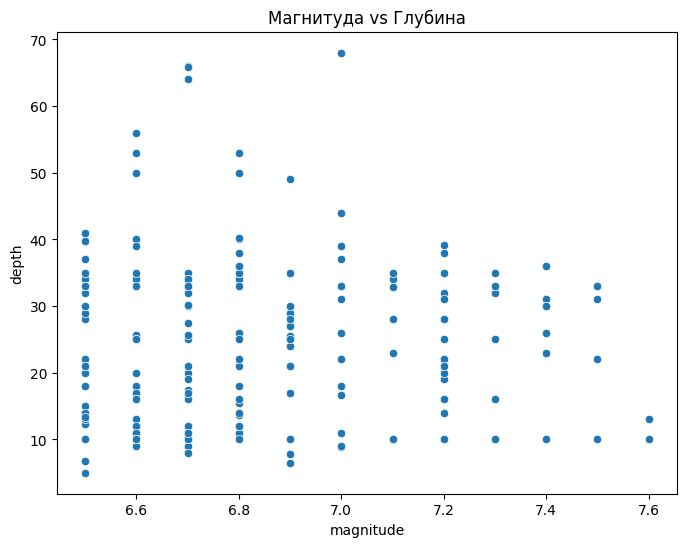

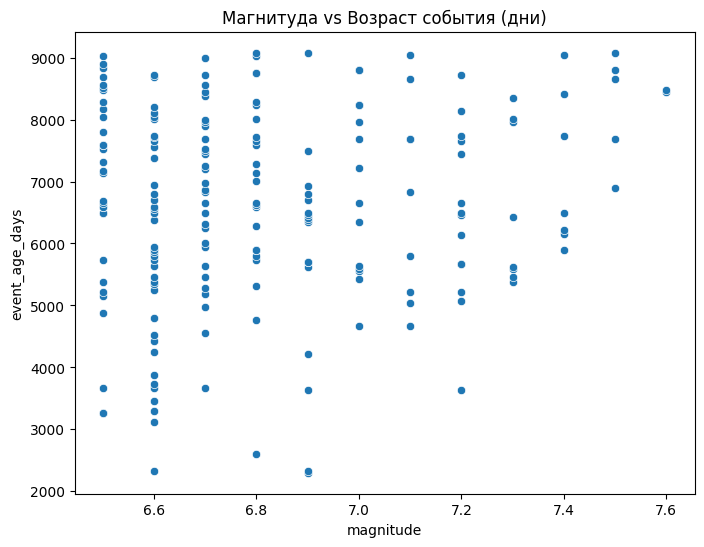

In [33]:
# 3. Графики зависимости
plt.figure(figsize=(8,6))
sns.scatterplot(x='magnitude', y='depth', data=df)
plt.title('Магнитуда vs Глубина')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='magnitude', y='event_age_days', data=df)
plt.title('Магнитуда vs Возраст события (дни)')
plt.show()

# 4. Применение метода K-means
features = ['magnitude', 'depth', 'event_age_days']
X = df[features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

df.loc[X.index, 'cluster'] = kmeans.labels_

plt.figure(figsize=(8,6))
sns.scatterplot(x=X['magnitude'], y=X['depth'], hue=kmeans.labels_, palette='viridis')
plt.title('Кластеры по магнитуде и глубине')
plt.show()

# Вывод

В ходе выполнения работы был проведен детальный анализ синтетического датасета, связанного с характеристиками землетрясений и рисками цунами. На первом этапе был добавлен вычисляемый атрибут - возраст события (число дней с даты землетрясения до текущего времени), что позволило расширить исходные данные новым значимым показателем. Затем произведена очистка данных: удалены дубликаты, заполнены пропуски, успешно устранены выбросы с помощью метода межквартильного размаха.

Построенные графики рассеяния показали зависимости между магнитудой, глубиной и возрастом событий, на которых отчетливо выделились некоторые скопления. С помощью алгоритма K-means данные были разбиты на 3 кластера, что позволило выявить группы землетрясений с различными характеристиками по глубине и магнитуде.

Такой подход демонстрирует эффективность комплексного анализа в задачах сейсмических данных, а выделенные кластеры могут быть полезны для дальнейшего углубленного исследования закономерностей возникновения цунами и оценки рисков. Результаты обеспечивают основу для применения машинного обучения и кластеризации в системах мониторинга природных катастроф, позволяя выделять группы событий для оперативного реагирования и прогнозирования.